Nama : Suwandi Ramadhan
# ===========================================================================
##                      PROJECT 3 : VOICE RECOGNITION
##              Klasifikasi Maksud Ucapan (Intent Classification)
# ===========================================================================

## Data & Algoritma Understanding

#### TUJUAN :
Project ini bertujuan untuk membangun model yang dapat mengenali dan
mengklasifikasikan maksud (intent) dari sebuah rekaman suara.

#### DATASET:
https://huggingface.co/datasets/PolyAI/minds14



#### <Strong>Data Field</Strong>

| Nama Kolom | Tipe Data | Keterangan |
|:----------:|:---------:|:----------:|
|`path `| String | Path to the audio file |
|`audio `| Dict | Audio object including loaded audio array, sampling rate and path ot audio |
|`transcription `| String | Transcription of the audio file |
|`english_transcription `| String | English transcription of the audio file |
|`intent_class `| Integer | Class id of intent |
|`lang_id `| Integer | Id of language |

#### <strong>Penggunaan Bahasa Pada Dataset</strong>
-`en-US`

#### <strong>Pengolahan Dataset</strong>
-`Pembagian Dataset` = <strong>Training</strong>(80%) dan <strong>Test</strong>(20%) <br>
-`Audio Preprocessing` = <strong>Resampling</strong>, Audio diseragamkan ke sampling rate 16000 Hz <br>


#### MODEL :
`Fine Tuning` model pre-trained Wav2Vec2
1. facebook/wav2vec2-base
2. facebook/wav2vec2-large-960h
3. jonatasgrosman/wav2vec2-large-xlsr-53-english

coba LSTM atau RNN / coba dataset lain <br> Feeature ekstaksi MFCC 

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display
from typing import Any, Dict, List, Union, Optional

import torch
from datasets import load_dataset, Audio as DatasetsAudio, ClassLabel
from transformers import (
    Wav2Vec2FeatureExtractor,
    Wav2Vec2ForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate
from sklearn.metrics import confusion_matrix, classification_report

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# LANGKAH 1: PERSIAPAN DATA

In [ ]:
print("Memuat dataset MINDS-14...")
dataset = load_dataset("PolyAI/minds14", name="en-US", split="train")

print("\nMengubah dataset ke DataFrame dan menyimpan ke CSV...")
df = dataset.to_pandas()

csv_path = "../data/minds14_en-US.csv"
df.to_csv(csv_path, index=False)
print(f"Dataset berhasil disimpan ke '{csv_path}'")

intent_names = dataset.features['intent_class'].names
print(f"\nJumlah kelas intent: {len(intent_names)}")

Memuat dataset MINDS-14...

Mengubah dataset ke DataFrame dan menyimpan ke CSV...
Dataset berhasil disimpan ke '../data/minds14_en-US.csv'

Jumlah kelas intent: 14


tidak harus convert ke CSV

- EKstraksi fitur
- 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   path                   563 non-null    object
 1   audio                  563 non-null    object
 2   transcription          563 non-null    object
 3   english_transcription  563 non-null    object
 4   intent_class           563 non-null    int64 
 5   lang_id                563 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 26.5+ KB


### 1.1.1. Visualisasi Distribusi Kelas
Melihat jumlah sampel untuk setiap kategori (intent) untuk memastikan dataset kita seimbang.

C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_21408\2129406621.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='intent_name', data=df, order=df['intent_name'].value_counts().index, palette='viridis')


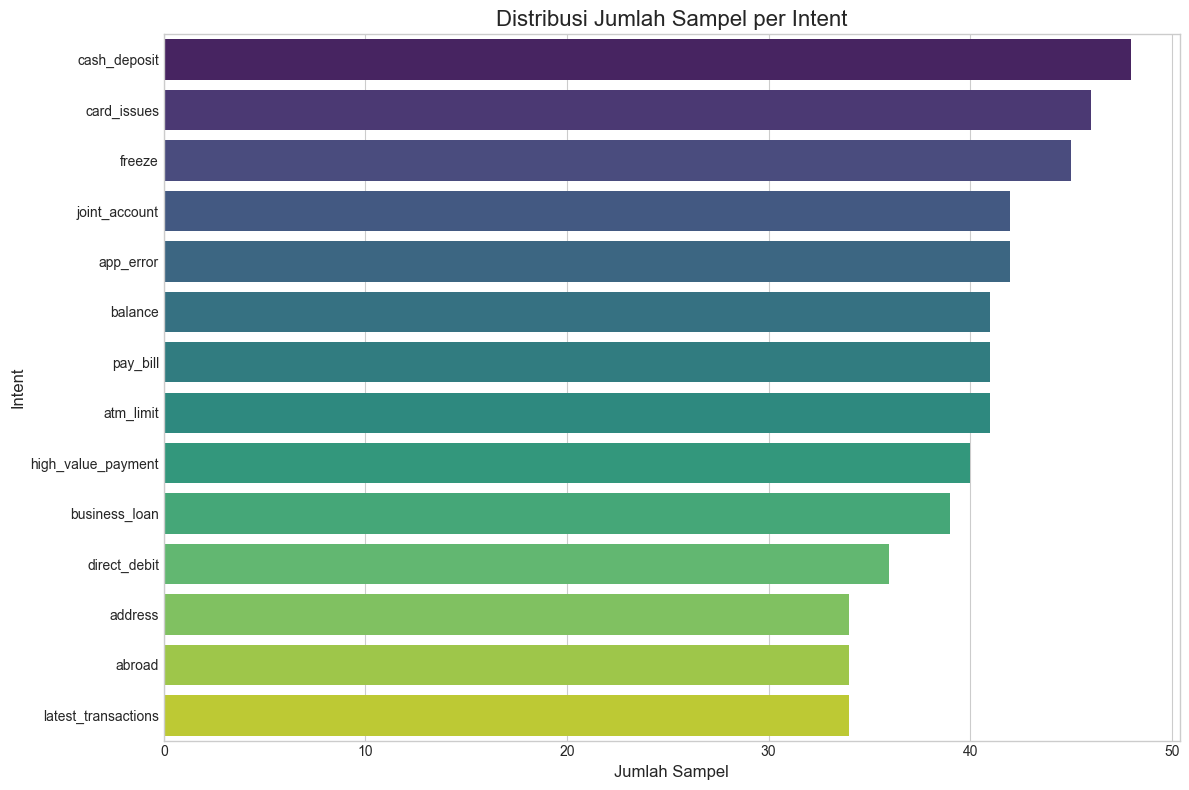

In [ ]:
df['intent_name'] = df['intent_class'].apply(lambda x: intent_names[x])

# Buat plot
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))
sns.countplot(y='intent_name', data=df, order=df['intent_name'].value_counts().index, palette='viridis')
plt.title('Distribusi Jumlah Sampel per Intent', fontsize=16)
plt.xlabel('Jumlah Sampel', fontsize=12)
plt.ylabel('Intent', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# MODEL_CHECKPOINT = "facebook/wav2vec2-base"
# MODEL_CHECKPOINT = "facebook/wav2vec2-large-960h"
MODEL_CHECKPOINT = "jonatasgrosman/wav2vec2-large-xlsr-53-english"

# Coba pakai tensor / pytorch untuk LSTM


feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_CHECKPOINT)

dataset = dataset.cast_column("audio", DatasetsAudio(sampling_rate=feature_extractor.sampling_rate))
print(f"\nDataset di-resample ke {feature_extractor.sampling_rate} Hz.")

# Fungsi untuk memproses audio
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * 5.0), # Batasi durasi
        truncation=True,
    )
    inputs["labels"] = examples["intent_class"]
    return inputs

# Terapkan fungsi preprocessing
processed_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset.column_names
)
print("Dataset telah diproses dengan feature extractor.")
print(f"Kolom baru di dataset: {processed_dataset.column_names}")

# Ubah kolom 'labels' menjadi ClassLabel untuk stratifikasi.
processed_dataset = processed_dataset.cast_column("labels", ClassLabel(num_classes=len(intent_names), names=intent_names))


# Bagi dataset menjadi training (80%) dan testing (20%) 
processed_dataset = processed_dataset.train_test_split(test_size=0.2, seed=42, stratify_by_column="labels")
df_train = processed_dataset["train"]

# Tambah data Val =====================================================================================================================================

df_test = processed_dataset["test"]

print("\nDataset telah dibagi :")
print(f"  - Ukuran Train set : {len(df_train)}")
print(f"  - Ukuran Test set : {len(df_test)}")


Dataset di-resample ke 16000 Hz.
Dataset telah diproses dengan feature extractor.
Kolom baru di dataset: ['input_values', 'attention_mask', 'labels']

Dataset telah dibagi :
  - Ukuran Train set : 450
  - Ukuran Test set : 113


# LANGKAH 2: TRAINING MODEL

In [ ]:
# Inisialisasi Model, Metrik, dan Data Collator

label2id = {label: i for i, label in enumerate(intent_names)}
id2label = {i: label for i, label in enumerate(intent_names)}

# Muat model pre-trained
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=len(intent_names),
    label2id=label2id,
    id2label=id2label,
)

# Definisikan metrik evaluasi
accuracy_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Buat Custom Data Collator
from dataclasses import dataclass

@dataclass
class CustomDataCollatorWithPadding:
    processor: Any
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    return_tensors: str = "pt"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        labels = [feature.pop("labels") for feature in features]
        batch = self.processor.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch["labels"] = torch.tensor(labels, dtype=torch.long)
        return batch

data_collator = CustomDataCollatorWithPadding(processor=feature_extractor, padding=True)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training
# Definisikan argumen training
training_args = TrainingArguments(
    output_dir="../model/voice-recognition-model-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,                         # Learning rate = 0.001
    per_device_train_batch_size=16,             # Bath Size = 32
    per_device_eval_batch_size=16,
    num_train_epochs=5,                         # Coba 10/20
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=torch.cuda.is_available(),
)

# Buat objek Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=df_train,
    eval_dataset=df_test,
    tokenizer=feature_extractor,
    data_collator=data_collator, 
    compute_metrics=compute_metrics,
)

print("\nMemulai training model...")
trainer.train()
print("Training selesai.")

C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_21408\3881520445.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Memulai training model...


C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,2.640100,2.628325,0.159292
2,2.621100,2.614590,0.185841
3,2.606600,2.602649,0.203540
4,2.584800,2.592295,0.185841
5,2.582300,2.587958,0.203540


C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\SUWAAAN\AppData\Local\

Training selesai.


# LANGKAH 3: ANALISIS & VISUALISASI HASIL

In [ ]:
# Evaluasi Model

print("\nMengevaluasi model pada test set...")
eval_results = trainer.evaluate()

print(f"\nHasil Evaluasi:")
print(f"  - Akurasi: {eval_results['eval_accuracy']:.4f}")
print(f"  - Loss: {eval_results['eval_loss']:.4f}")


Mengevaluasi model pada test set...


C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Hasil Evaluasi:
  - Akurasi: 0.2035
  - Loss: 2.6026


### 3.2. Visualisasi Kurva Training & Validasi
Chart ini membantu kita melihat bagaimana performa model meningkat (atau tidak) di setiap epoch. Kita bisa mendeteksi *overfitting* jika *training loss* terus turun sementara *validation loss* mulai naik.

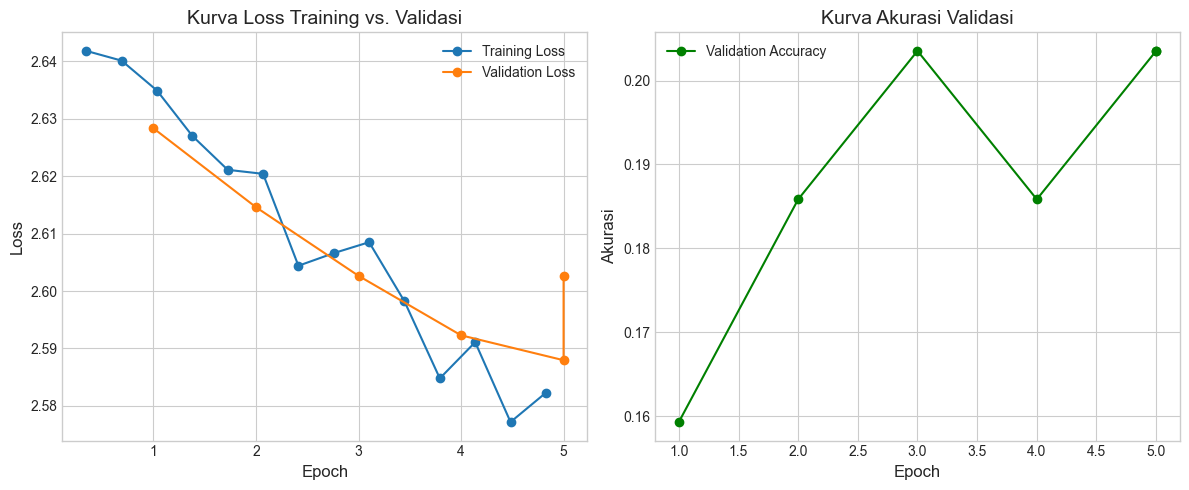

In [9]:
# Ekstrak history dari log trainer
log_history = trainer.state.log_history

# Pisahkan log training dan evaluasi
training_logs = [log for log in log_history if 'loss' in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

# Siapkan data untuk plot
train_epochs = [log['epoch'] for log in training_logs]
train_losses = [log['loss'] for log in training_logs]
eval_epochs = [log['epoch'] for log in eval_logs]
eval_losses = [log['eval_loss'] for log in eval_logs]
eval_accuracies = [log['eval_accuracy'] for log in eval_logs]

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_losses, 'o-', label='Training Loss')
plt.plot(eval_epochs, eval_losses, 'o-', label='Validation Loss')
plt.title('Kurva Loss Training vs. Validasi', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_accuracies, 'o-', label='Validation Accuracy', color='g')
plt.title('Kurva Akurasi Validasi', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 3.3. Confusion Matrix dan Classification Report

Membuat prediksi pada df_test untuk analisis...


C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Classification Report ---

                     precision    recall  f1-score   support

             abroad       0.00      0.00      0.00         7
            address       0.00      0.00      0.00         7
          app_error       0.00      0.00      0.00         8
          atm_limit       0.00      0.00      0.00         8
            balance       0.26      0.75      0.39         8
      business_loan       0.00      0.00      0.00         8
        card_issues       0.09      0.33      0.15         9
       cash_deposit       0.19      0.70      0.30        10
       direct_debit       0.00      0.00      0.00         7
             freeze       0.21      0.44      0.29         9
 high_value_payment       0.00      0.00      0.00         8
      joint_account       1.00      0.11      0.20         9
latest_transactions       0.00      0.00      0.00         7
           pay_bill       1.00      0.25      0.40         8

           accuracy                           0.20 

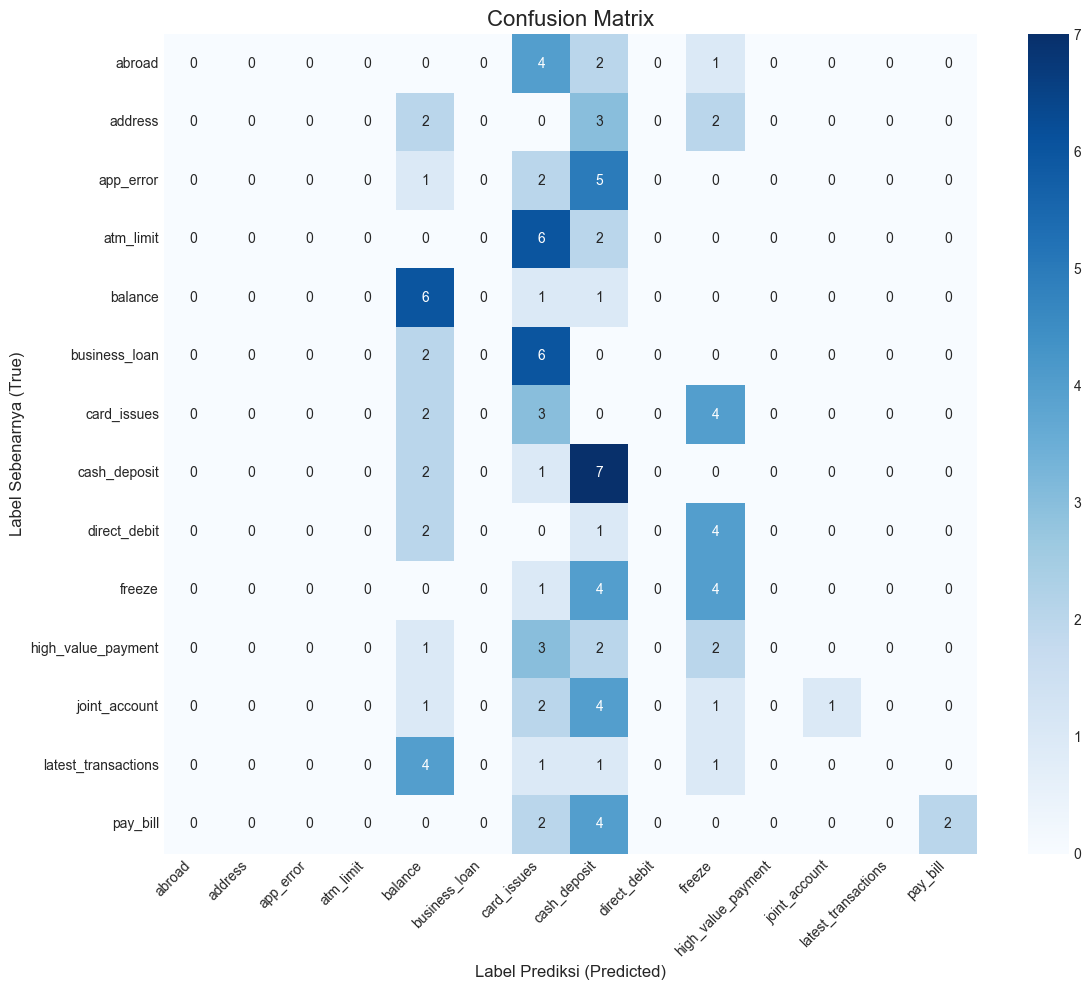

In [ ]:
print("Membuat prediksi pada df_test untuk analisis...")
predictions, labels, _ = trainer.predict(df_test)
y_preds = np.argmax(predictions, axis=1)
y_true = labels

# Classification Report
print("\n--- Classification Report ---\n")
report = classification_report(y_true, y_preds, target_names=intent_names, zero_division=0)
print(report)

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_preds)

# Visualisasi Confusion Matrix dengan Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=intent_names, yticklabels=intent_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Label Sebenarnya (True)', fontsize=12)
plt.xlabel('Label Prediksi (Predicted)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# LANGKAH 4: UJI COBA (INFERENCE)

In [ ]:
# Uji Coba Model pada Satu Audio

# Tentukan device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ambil satu sampel acak langsung dari dataset 
random_index = random.randint(0, len(dataset) - 1)
random_sample = dataset[random_index]

print(f"Menguji sampel acak #{random_index} dari dataset asli.")

# Ambil data dari sampel yang dipilih
audio_array_original = random_sample['audio']['array']
sr_original = random_sample['audio']['sampling_rate']
transcription_original = random_sample['transcription']
true_label_id = random_sample['intent_class']
true_label_name = model.config.id2label[true_label_id]

# Proses sampel audio yang dipilih 
inputs = feature_extractor(
    audio_array_original,
    sampling_rate=feature_extractor.sampling_rate,
    return_tensors="pt",
    padding=True
)
input_values = inputs.input_values.to(device)

# Lakukan prediksi
with torch.no_grad():
    logits = model(input_values).logits

# Hasil prediksi
predicted_id = torch.argmax(logits, dim=-1).item()
predicted_label = model.config.id2label[predicted_id]

print(f"\nTranskripsi Asli: '{transcription_original}'")
print(f"Intent Sebenarnya: {true_label_name}")
print(f"Prediksi Intent Model: {predicted_label}")

if predicted_label == true_label_name:
    print("\n✅ Prediksi Benar!")
else:
    print("\n❌ Prediksi Salah.")

print("\nMemutar audio yang diuji:")
display(Audio(data=audio_array_original, rate=sr_original))

Menguji sampel acak #114 dari dataset asli.

Transkripsi Asli: 'hello I'm calling to pay for my electric and water bill or can I make this payment'
Intent Sebenarnya: pay_bill
Prediksi Intent Model: cash_deposit

❌ Prediksi Salah.

Memutar audio yang diuji:
